# Decision Tree Model

In [2]:
import pathlib
import importlib
import re

import pandas as pd
import numpy as np
import feather
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import f1_score, roc_curve, auc, roc_auc_score
from scikitplot.metrics import plot_confusion_matrix
from scikitplot.metrics import plot_roc
from sklearn.model_selection import GridSearchCV
from sklearn import tree

In /Users/hudson/ds/ds_test/env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/hudson/ds/ds_test/env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/hudson/ds/ds_test/env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/hudson/ds/ds_test/env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/hudson/ds/ds_test/env/lib/

In [3]:
DATA_PATH = pathlib.Path('./data')
RESULTS_PATH = pathlib.Path('./results')

In [4]:
X_train = feather.read_dataframe(DATA_PATH / 'X_train')
y_train = feather.read_dataframe(DATA_PATH / 'y_train')
y_train = y_train['target']
X_test = feather.read_dataframe(DATA_PATH / 'X_test')
y_test = feather.read_dataframe(DATA_PATH / 'y_test')
y_test = y_test['target']

In [5]:
DecisionTreeClassifier?

Init signature:
DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    class_weight=None,
    presort=False,
)
Docstring:     
A decision tree classifier.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
criterion : string, optional (default="gini")
    The function to measure the quality of a split. Supported criteria are
    "gini" for the Gini impurity and "entropy" for the information gain.

splitter : string, optional (default="best")
    The strategy used to choose the split at each node. Supported
    strategies are "best" to choose the best split and "random" to choose
    the best random split.

max_depth : int or None, optional (default=None)
    The maximum depth of the tree. If None, then nodes are expanded unt

In [6]:
dt = DecisionTreeClassifier(class_weight='balanced')

In [7]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [8]:
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

Due to the dominance of labels 0 in our data, we should not use accuracy as a measure of performance.

Instead, we care about how many True Positives (TP), how many False Positives (FP) and how many False Negatives (FN) we have.

The ideal model would have no FP nor FN.

It is common to define a matrix that looks like this to visualize model performance

TN  |  FP
----------
FN  |  TP
----------

This is known as the confusion matrix

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

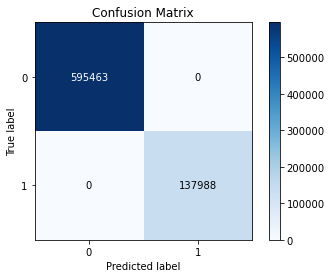

In [9]:
plot_confusion_matrix(y_train, y_train_pred, normalize=False)

Seems like we have the perfect model, but this is the data we used for training.
Does it **generalize**?

Let's try to guess what will happen if the model is not good and assignments are random

In [10]:
len(y_test)

293094

In [11]:
y_test.value_counts()

0    224852
1     68242
Name: target, dtype: int64

In [12]:
y_test.value_counts()/len(y_test)

0    0.767167
1    0.232833
Name: target, dtype: float64

Let's say we have a model with little skill. It simply notices that the probability of finding a 1 is 23%, then assign 1's with probability 23%, and 0 with 77%, no matter what features it sees.

How many true positives would we have?

In [13]:
68242*0.23

15695.66

And how many false negatives?

In [14]:
68242*0.77

52546.340000000004

How about true negatives?

In [15]:
224852*0.77

173136.04

Finally, false positive:

In [16]:
224852*0.23

51715.96

## Summary:
------
TN ~ 170K  |  FP ~ 52K
------
FN ~ 52K       |   TP ~ 16k
------

## Confusion matrix for the test set

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

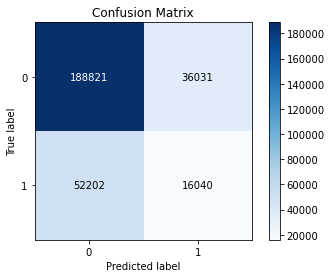

In [17]:
plot_confusion_matrix(y_test, y_test_pred, normalize=False)

It is standard to quote these numbers in terms of RATES, so they don't depend on the sample size
Instead of TP, we have TPR: for every positive, how many actually positive? 

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

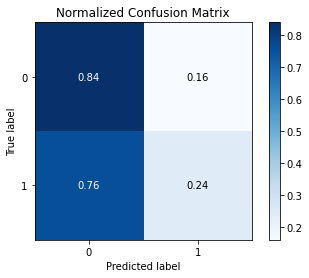

In [18]:
plot_confusion_matrix(y_test, y_test_pred, normalize=True)

The confusion matrix reveals that:
* The model is doing slightly better than random when it comes to class 0, as 189k > 170k -- but not great
* The model is mostly behaving like a random model when it comes to class 1, as these numbers closely match 

Our goal TPR while decreasing FPR (or at least keeping it the same). 

Increasing TPR while also increasing FPR may not necessarily be good.
- For example, you can always achieve a TPR of 1 by simply saying everything is positive
- But then FPR is also 1


# ROC Curve

In [19]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

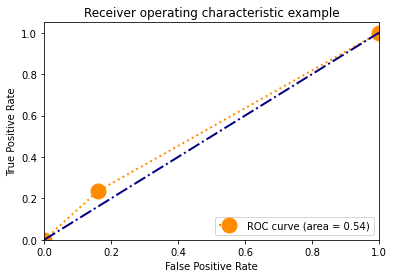

In [20]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, marker='o', markersize='15', ls=':')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='-.')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

The straight line is the baseline.
In this case, the probability of getting a positive, whether true or false, is the same, because the model is not smart.
Thus, TPR = FPR

The dot is the (FPR, TPR) for our tree. For the tree we have a single point. 

Some other models, like logistic regression, allow for the **tuning of a threshold**, which then changes the FPR and TPR's. This produces a (more) continuous curve.

Problem: we are overfitting because the tree can grow arbitrarily large. 

In [21]:
dt.tree_.max_depth

65

What is happening to the rates as the tree grows?

In [22]:
depths = range(1,30)
fpr_vector = []
tpr_vector = []
fpr_vector_train = []
tpr_vector_train = []
for depth in depths:
    model = DecisionTreeClassifier(class_weight='balanced', max_depth=depth)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    false_pos_rate, true_pos_rate, _ = roc_curve(y_test, test_pred)
    false_pos_rate_train, true_pos_rate_train, _ = roc_curve(y_train, train_pred)
    fpr_vector.append(false_pos_rate[1])
    tpr_vector.append(true_pos_rate[1])
    fpr_vector_train.append(false_pos_rate_train[1])
    tpr_vector_train.append(true_pos_rate_train[1])

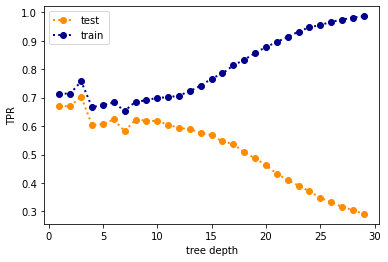

In [23]:
plt.plot(depths, tpr_vector, color='darkorange',
         lw=lw, marker='o', markersize='6', ls=':', label='test')
plt.plot(depths, tpr_vector_train, color='darkblue',
         lw=lw, marker='o', markersize='6', ls=':', label='train')
plt.xlabel("tree depth")
plt.ylabel("TPR")
plt.legend()

Text(0, 0.5, 'FPR')

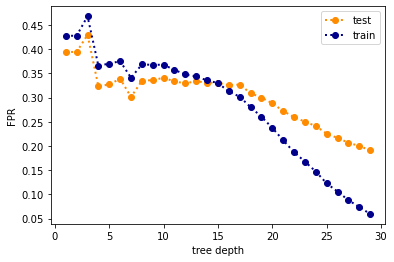

In [24]:
plt.plot(depths, fpr_vector, color='darkorange',
         lw=lw, marker='o', markersize='6', ls=':', label='test')
plt.plot(depths, fpr_vector_train, color='darkblue',
         lw=lw, marker='o', markersize='6', ls=':', label='train')
plt.legend()
plt.xlabel("tree depth")
plt.ylabel("FPR")

This was done for illustration purposes:
every point requires training a new model, so generating these curves is expensive

(0.0, 1.05)

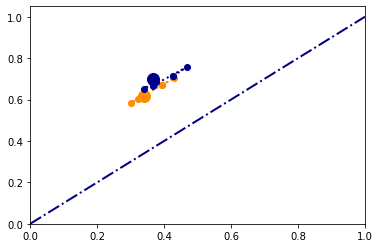

In [25]:
plt.plot(fpr_vector[0:10], tpr_vector[0:10], color='darkorange',
         lw=lw, marker='o', markersize='6', ls=':', label='test')
plt.plot(fpr_vector[9:10], tpr_vector[9:10], color='darkorange',
         lw=lw, marker='o', markersize='12', ls=':', label='test')

plt.plot(fpr_vector_train[0:10], tpr_vector_train[0:10], color='darkblue',
         lw=lw, marker='o', markersize='6', ls=':', label='test')
plt.plot(fpr_vector_train[9:10], tpr_vector_train[9:10], color='darkblue',
         lw=lw, marker='o', markersize='12', ls=':', label='test')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='-.')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Optimizing the Model Search: GridSearch

In [26]:
param_grid = {
    'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'min_samples_split': [2, 20],
    'min_samples_leaf': [1, 10, 100],
    'min_impurity_decrease': [0.0005, 0.001, 0.005, 0.01],
    'random_state': [42],
    'class_weight': [None, 'balanced']
    }

In [27]:
clf = GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid=param_grid,
             scoring='f1_macro',
             n_jobs=-1,
             verbose=2)

In [28]:
clf.fit(X_train, y_train)

Fitting 3 folds for each of 528 candidates, totalling 1584 fits
/Users/hudson/ds/ds_test/env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 325 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 973 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1418 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 1584 out of 1584 | elapsed: 11.7min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14

In [29]:
clf.best_params_

{'class_weight': 'balanced',
 'max_depth': 5,
 'min_impurity_decrease': 0.001,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'random_state': 42}

In [30]:
y_test_pred2 = clf.predict(X_test)
y_train_pred2 = clf.predict(X_train)

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

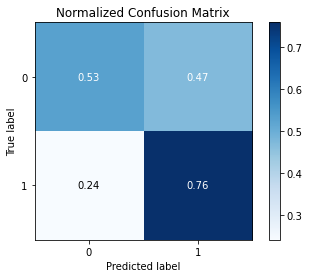

In [49]:
plot_confusion_matrix(y_train, y_train_pred2, normalize=True)

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

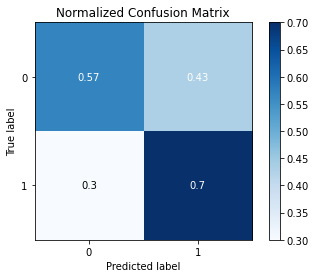

In [31]:
plot_confusion_matrix(y_test, y_test_pred2, normalize=True)

In [32]:
fpr2, tpr2, _ = roc_curve(y_test, y_test_pred2)
roc_auc2 = auc(fpr2, tpr2)

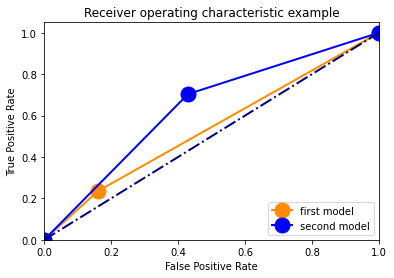

In [50]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='first model' % roc_auc, marker='o', markersize='15')
plt.plot(fpr2, tpr2, color='blue',
         lw=lw, label='second model' % roc_auc2, marker='o', markersize='15')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='-.')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [53]:
tpr2[1], fpr2[1]

(0.7037161865127047, 0.429495846156583)

# Precision and Recall

In [34]:
print(classification_report(y_test, y_test_pred2))

              precision    recall  f1-score   support

           0       0.86      0.57      0.69    224852
           1       0.33      0.70      0.45     68242

    accuracy                           0.60    293094
   macro avg       0.60      0.64      0.57    293094
weighted avg       0.74      0.60      0.63    293094



# Feature Importance

In [35]:
feature_importance = pd.DataFrame(zip(X_train.columns, clf.best_estimator_.feature_importances_), columns=['feature', 'importance'])

In [36]:
feature_importance = feature_importance.sort_values(by=['importance'], ascending=False)
feature_importance.index = feature_importance['feature']

In [37]:
feature_importance.head()

,feature,importance
feature,,
sub_grade,sub_grade,0.856021
term,term,0.143979
addr_state,addr_state,0.000000
annual_inc,annual_inc,0.000000
total_acc,total_acc,0.000000


<AxesSubplot:xlabel='feature'>

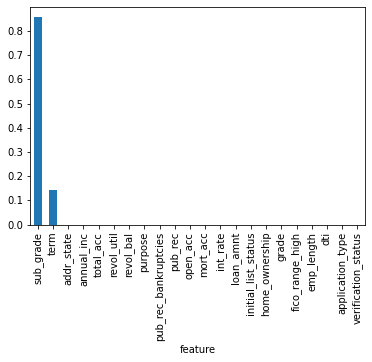

In [38]:
feature_importance['importance'].plot(kind='bar')

# Visualizing the tree

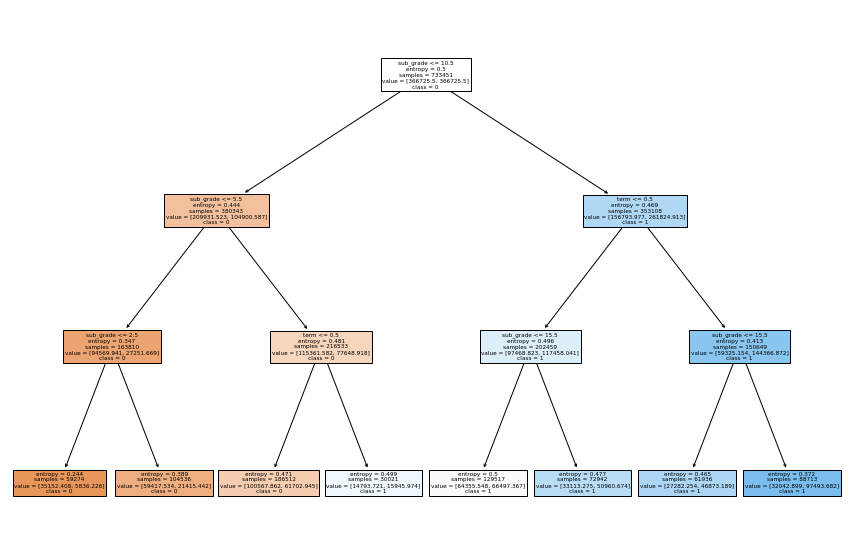

In [46]:
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(
    clf.best_estimator_,
    feature_names=X_train.columns,
    class_names=['0', '1'],
    filled=True
)